In [1]:
suppressPackageStartupMessages({

library(GenomicRanges)
library(rtracklayer)
library(VariantAnnotation)
library(tidyverse)
library(glue)
library(here)
library(bdkn)

})

In [4]:
get_lengths <- function(bam) { 
    lengths <- paste("samtools view ", bam, " | cut -f10 | awk '{print length($0)}'") %>%
        pipe %>%
        scan
    name <- basename(bam) %>% str_replace_all("^[a-z]+_|.bam$", "")
    regions <- basename(bam) %>% str_replace_all("^([a-z]+)_.*", "\\1")
    
    tibble(name = name, regions = regions, length = lengths)
}

In [5]:
length_df <-
    list.files(here("data/bam"), ".*.bam$", full.names = TRUE) %>%
    str_subset("control", negate = TRUE) %>%
    map_dfr(get_lengths) %>%
    mutate(set = case_when(
        name %in% c("denisova8", "spy1", "mez2", "elsidron1", "elsidron2") ~ "capture",
        name %in% c("bichon", "kk1", "loschbour", "mota", "ustishim") ~ "shotgun_ancient",
        TRUE ~ "shotgun_modern"
    ))

In [27]:
length_df %>%
group_by(name, regions) %>%
summarise(length = mean(length)) %>%
spread(regions, length)

name,exome,full,lippold
a00,98.82413,99.21773,99.05627
a00_1,98.60653,99.06772,98.86041
a00_2,98.98447,99.32766,99.19952
bichon,79.86074,81.25773,80.58939
comb_neand,NA,53.51526,NA
denisova8,NA,44.77619,44.34728
elsidron1,63.21513,NA,NA
elsidron2,NA,NA,55.33982
kk1,56.05111,55.15007,54.61898
loschbour,77.35585,73.37640,74.70133


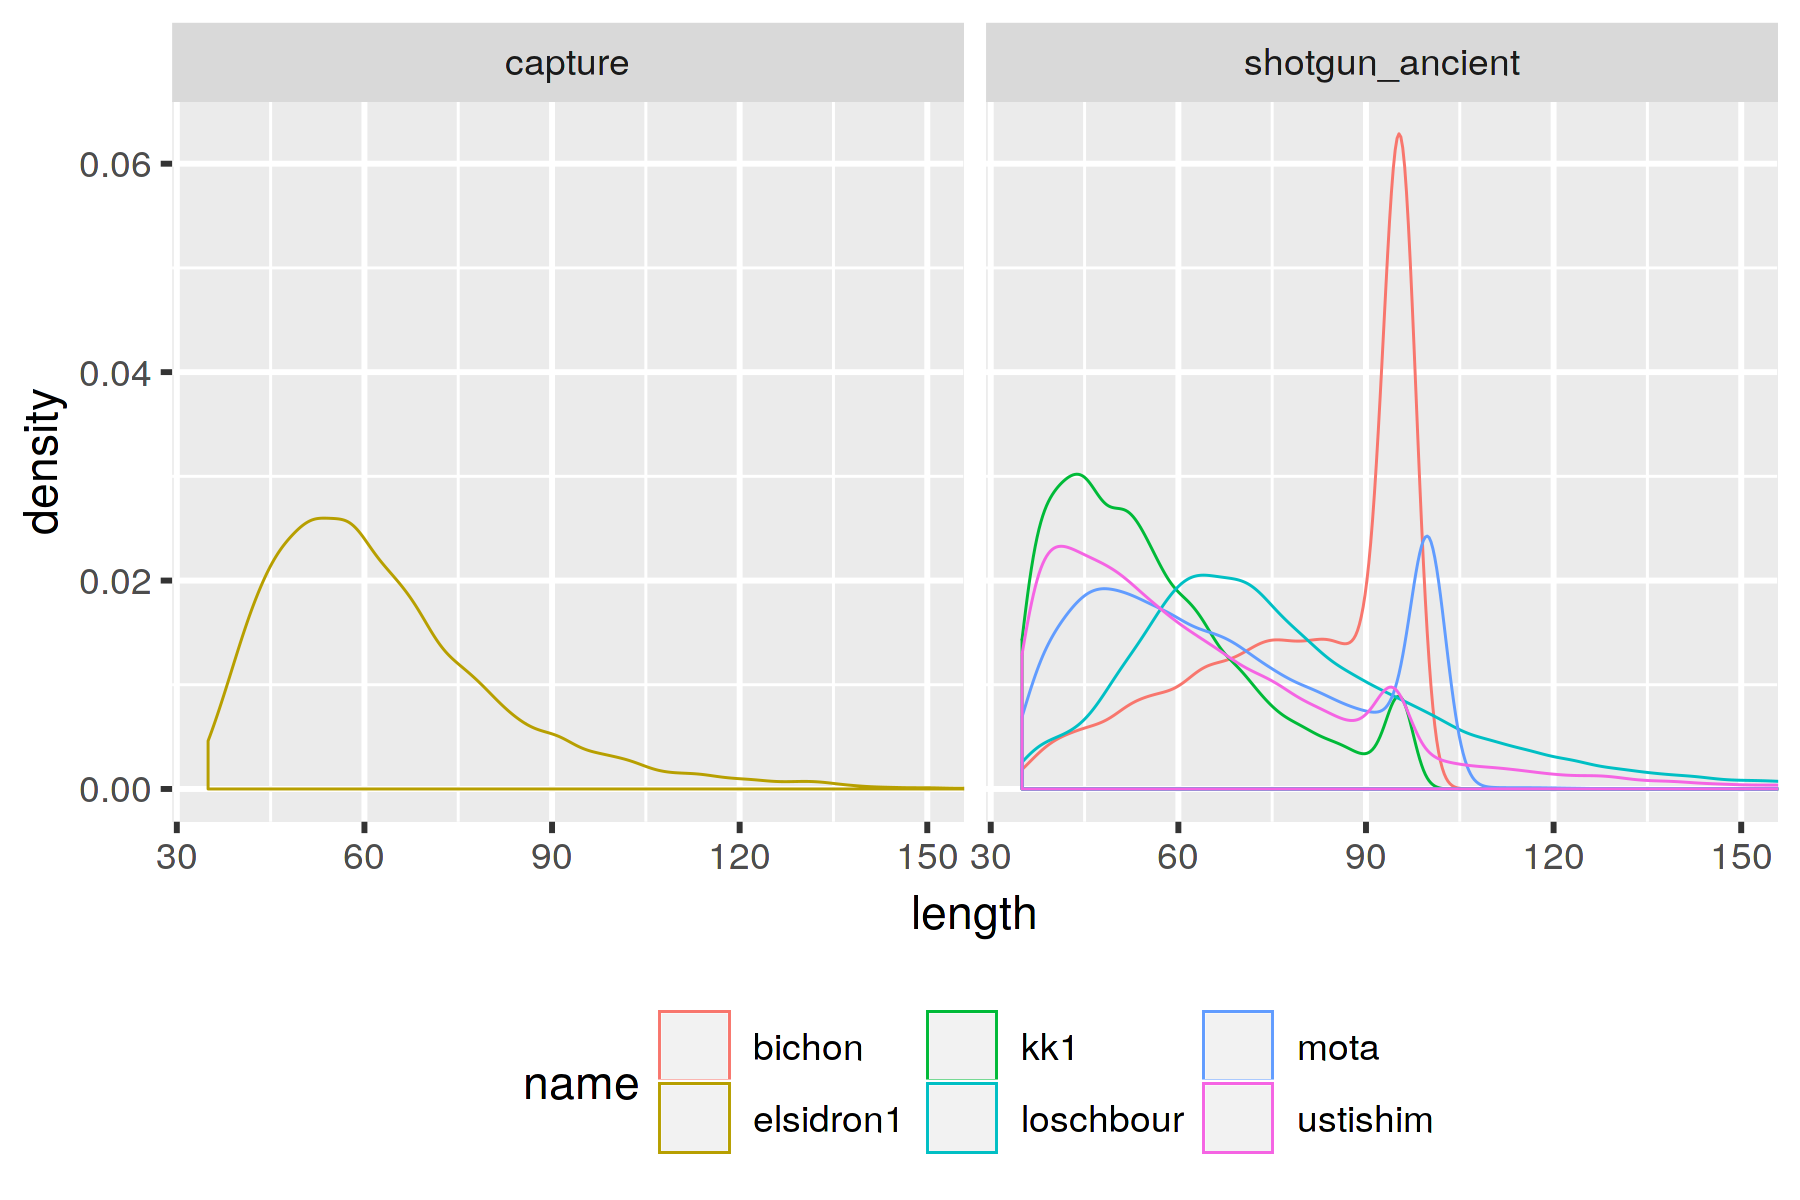

In [25]:
set_dim(6, 4, 300)

filter(length_df, regions == "exome", set != "shotgun_modern") %>%
ggplot(aes(length, color = name)) +
    geom_density(size = 0.25) +
    facet_wrap(~ set) +
    coord_cartesian(x = c(35, 150)) +
    theme(legend.position = "bottom")

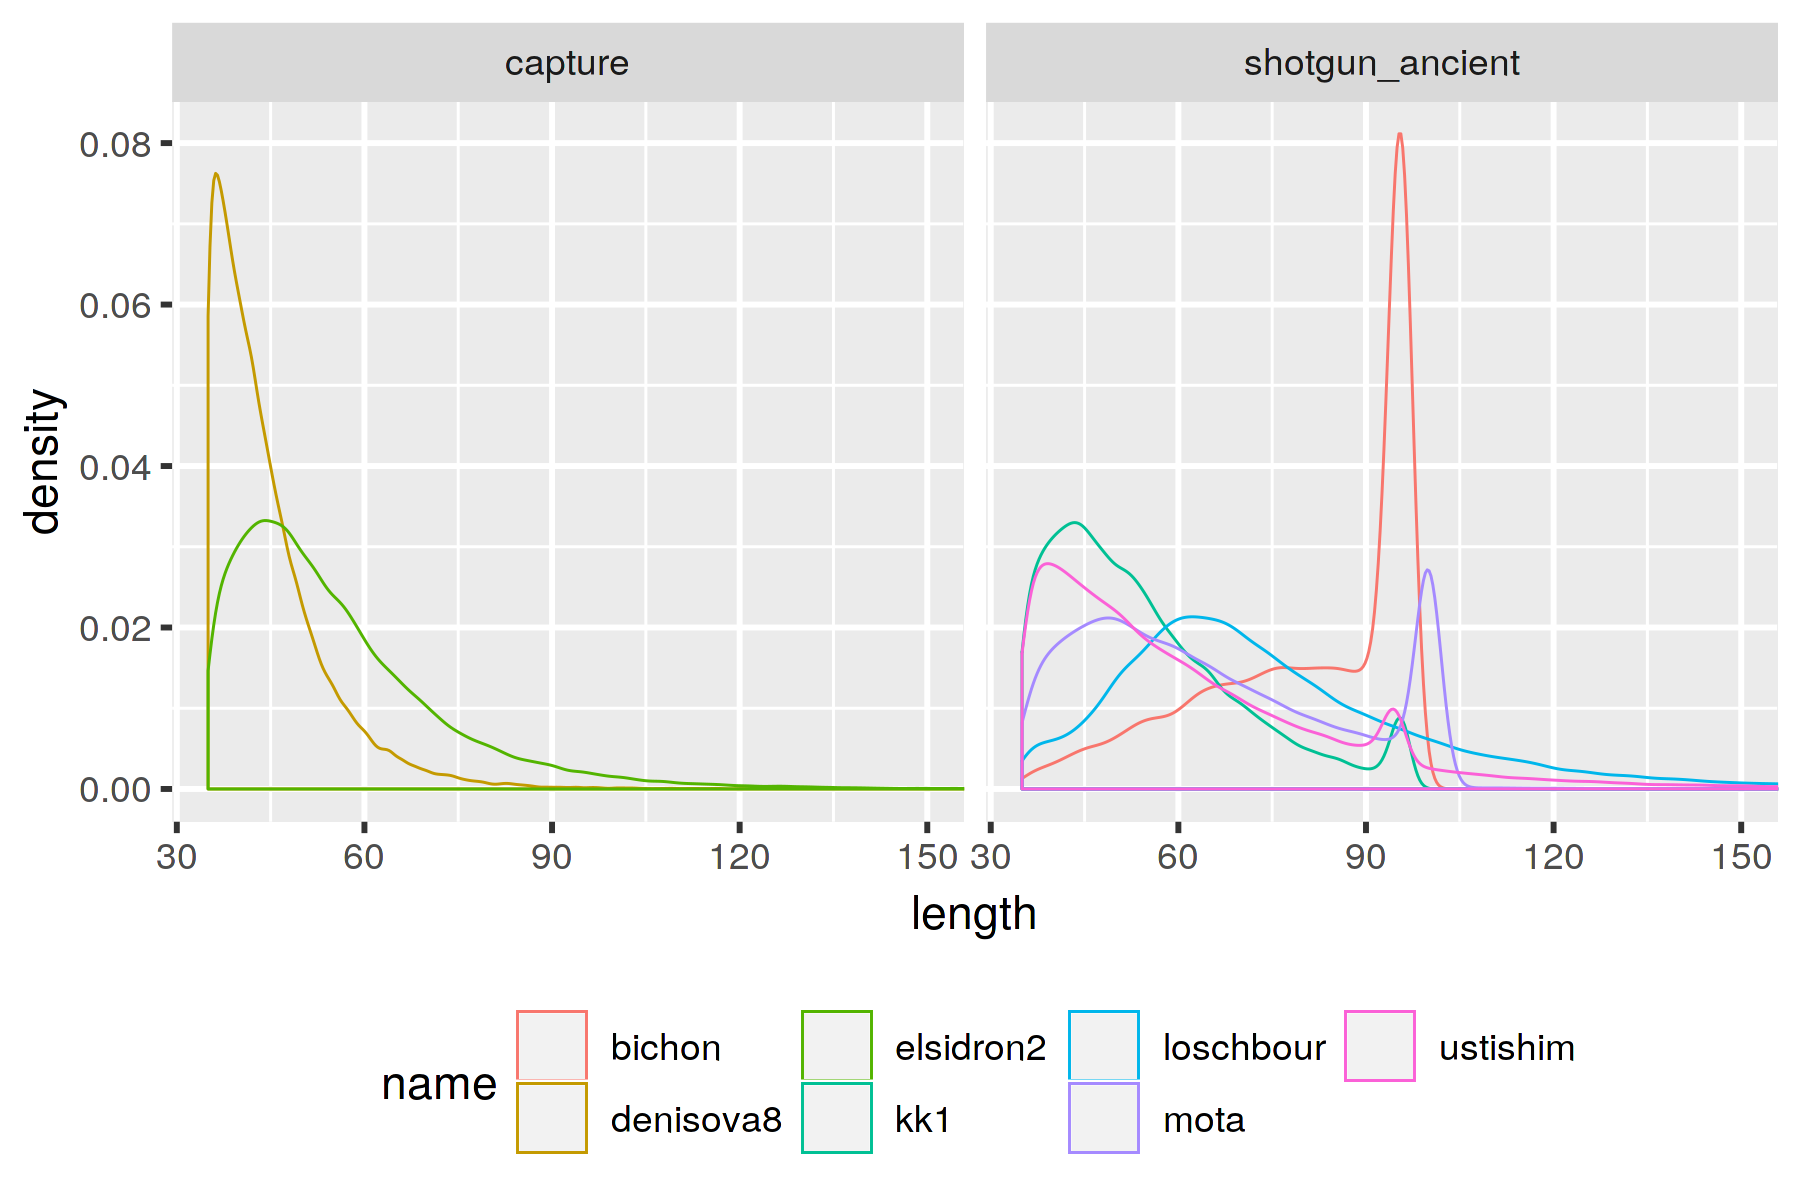

In [26]:
set_dim(6, 4, 300)

filter(length_df, regions == "lippold", set != "shotgun_modern") %>%
ggplot(aes(length, color = name)) +
    geom_density(size = 0.25) +
    facet_wrap(~ set) +
    coord_cartesian(x = c(35, 150)) +
    theme(legend.position = "bottom")

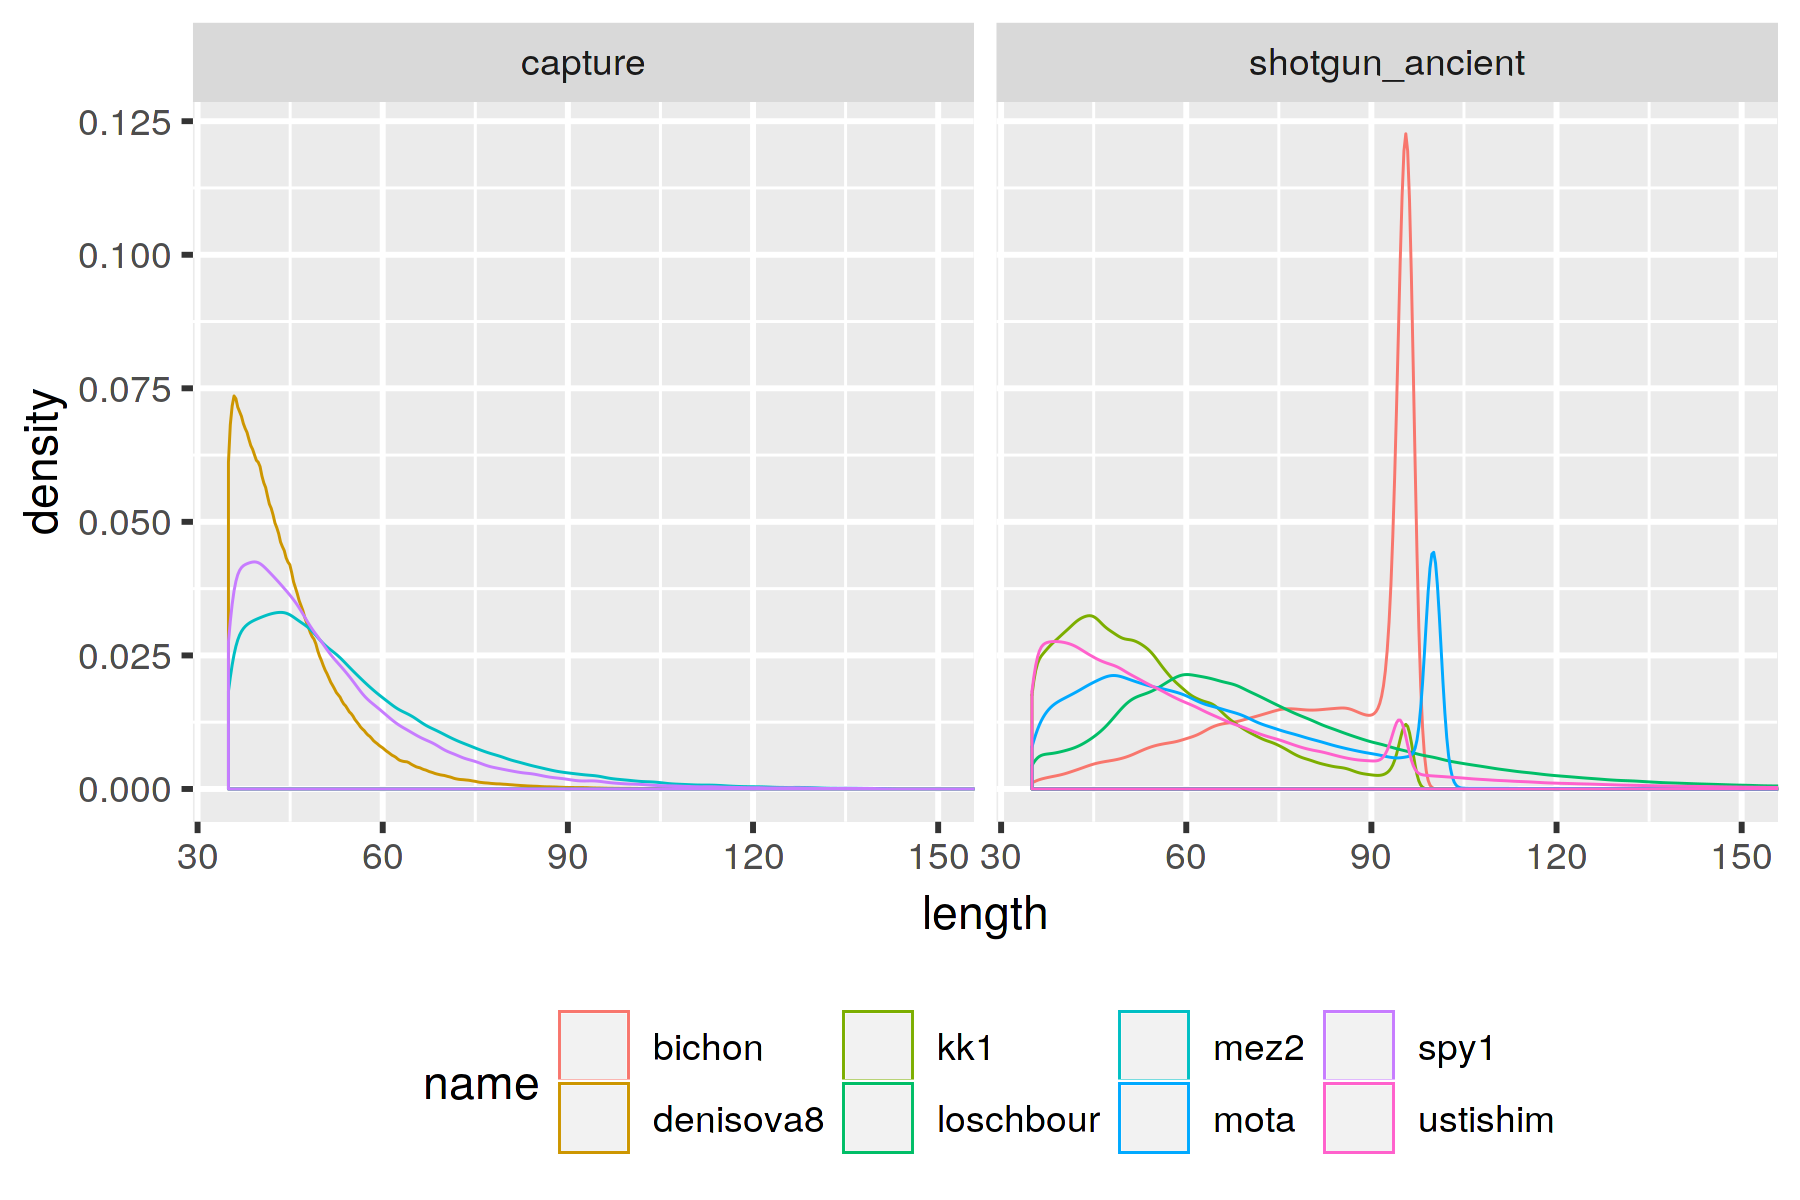

In [28]:
set_dim(6, 4, 300)

filter(length_df, regions == "full", set != "shotgun_modern") %>%
ggplot(aes(length, color = name)) +
    geom_density(size = 0.25) +
    facet_wrap(~ set) +
    coord_cartesian(x = c(35, 150)) +
    theme(legend.position = "bottom")